In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from kmodes.kprototypes import KPrototypes

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator

from sklearn.decomposition import PCA


from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")


frTRAIN = 0.8               # % size of training dataset
RNDN = 42                   # random state
nK = 12                     # initial guess: clusters


%matplotlib inline
pd.set_option("display.precision",2)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

In [41]:
# read sales data
dfa0 = pd.read_csv("telco_data.csv")
dfa1 = dfa0.copy()
dfa1.tail(2)

,customerID,gender,Partner,Dependents,tenure,PhoneService,InternetService,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,SeniorCitizen
7041,8361-LTMKD,Male,Yes,No,4,Yes,Fiber optic,No,Month-to-month,Yes,Mailed check,74.400,Yes,1
7042,3186-AJIEK,Male,No,No,66,Yes,Fiber optic,Yes,Two year,Yes,Bank transfer (automatic),105.650,No,0


In [42]:
# any missing values?
dfa1.isnull().values.any()

False

In [43]:
dfa1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   StreamingTV       7043 non-null   object 
 8   Contract          7043 non-null   object 
 9   PaperlessBilling  7043 non-null   object 
 10  PaymentMethod     7043 non-null   object 
 11  MonthlyCharges    7043 non-null   float64
 12  Churn             7043 non-null   object 
 13  SeniorCitizen     7043 non-null   int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 770.5+ KB


In [44]:
# type conversions
dfa1["tenure"] = dfa1["tenure"].astype(np.float64)
dfa1["SeniorCitizen"] = dfa1["SeniorCitizen"].astype(object)

In [45]:
# unique categorical elements per column
print(dfa1.select_dtypes("object").nunique())

# numerical variables
dfa1.select_dtypes(exclude='object').describe()

customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
InternetService        3
StreamingTV            3
Contract               3
PaperlessBilling       2
PaymentMethod          4
Churn                  2
SeniorCitizen          2
dtype: int64


,tenure,MonthlyCharges
count,7043.000,7043.000
mean,32.371,64.762
std,24.559,30.090
min,0.000,18.250
25%,9.000,35.500
50%,29.000,70.350
75%,55.000,89.850
max,72.000,118.750


## A1. Translate Categories to Numerical Variables - kMeans

In [46]:
# drop the order ID column, meaningless for clustering
dfa2 = dfa1.copy()
dfa2 = dfa1.drop("customerID", axis=1)
dfa3 = dfa2.copy()

In [47]:
# scale the numerical variables
numcols = list(dfa3.dtypes[dfa3.dtypes == "float64"].index)
print(numcols)
scaler = StandardScaler()
dfa3[numcols] = scaler.fit_transform(dfa3[numcols])
dfa3.describe()

['tenure', 'MonthlyCharges']


,tenure,MonthlyCharges
count,7043.000,7043.000
mean,-0.000,-0.000
std,1.000,1.000
min,-1.318,-1.546
25%,-0.952,-0.973
50%,-0.137,0.186
75%,0.921,0.834
max,1.614,1.794


In [48]:
# helper function: translate category column to numerical column
def catcode(df, col): 
    df[col + "_n"] = df[col].astype("category").cat.codes
    df = df.drop(col, axis=1, inplace=True)

In [49]:
# create numerical columns from categories
_ = [catcode(dfa3, col) for col in list(dfa3.dtypes[dfa3.dtypes == np.object].index)]
print(dfa3.select_dtypes(exclude="object").nunique())
dfa3.describe()

tenure                  73
MonthlyCharges        1585
gender_n                 2
Partner_n                2
Dependents_n             2
PhoneService_n           2
InternetService_n        3
StreamingTV_n            3
Contract_n               3
PaperlessBilling_n       2
PaymentMethod_n          4
Churn_n                  2
SeniorCitizen_n          2
dtype: int64


,tenure,MonthlyCharges,gender_n,Partner_n,Dependents_n,PhoneService_n,InternetService_n,StreamingTV_n,Contract_n,PaperlessBilling_n,PaymentMethod_n,Churn_n,SeniorCitizen_n
count,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000
mean,-0.000,-0.000,0.505,0.483,0.300,0.903,0.873,0.985,0.690,0.592,1.574,0.265,0.162
std,1.000,1.000,0.500,0.500,0.458,0.296,0.738,0.885,0.834,0.491,1.068,0.442,0.369
min,-1.318,-1.546,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.952,-0.973,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
50%,-0.137,0.186,1.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,2.000,0.000,0.000
75%,0.921,0.834,1.000,1.000,1.000,1.000,1.000,2.000,1.000,1.000,2.000,1.000,0.000
max,1.614,1.794,1.000,1.000,1.000,1.000,2.000,2.000,2.000,1.000,3.000,1.000,1.000


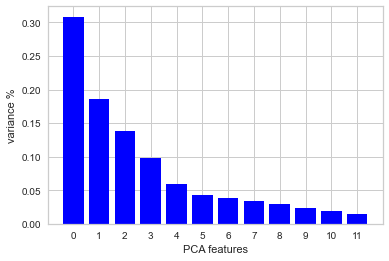

In [50]:
# principal components
pca = PCA(n_components=12)
res_pca = pca.fit_transform(dfa3)

# scree plot
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color="blue")
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

dfa3_pca = pd.DataFrame(res_pca)

In [51]:
# elbow score plot with Yellowbrick
def elbowplot(df, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  


  0%|          | 0/3 [00:00<?, ?it/s]

Elbow Score Plot (distortion metric):
elbow value = optimal k: 6  | elbow score: 22,154.190


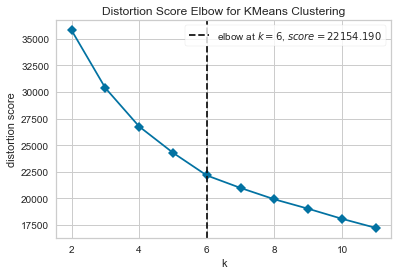

 33%|███▎      | 1/3 [00:03<00:06,  3.17s/it]

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 3  | elbow score: 0.221


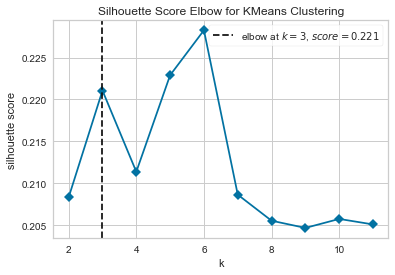

 67%|██████▋   | 2/3 [00:15<00:08,  8.43s/it]

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 2  | elbow score: 2,008.996


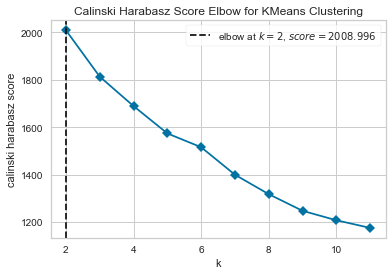

100%|██████████| 3/3 [00:18<00:00,  6.09s/it]


In [52]:
# call elbow plot for each of 3 alternative metrics
    # distortion = mean sum of squared distances to center
    # silhouette = mean ratio of intra-cluster and nearest-cluster distance
    # calinski = ratio of within to between cluster dispersion

model = KMeans(random_state=RNDN)
_ = [elbowplot(dfa3, m, model) for m in tqdm(["distortion", "silhouette", "calinski_harabasz"])]

inertia scores (sum of squared errors) by number of clusters:
2 : 35,795
3 : 30,366
4 : 26,751
5 : 24,287
6 : 22,154
7 : 20,978
8 : 19,912
9 : 19,026
10 : 18,080
11 : 17,226


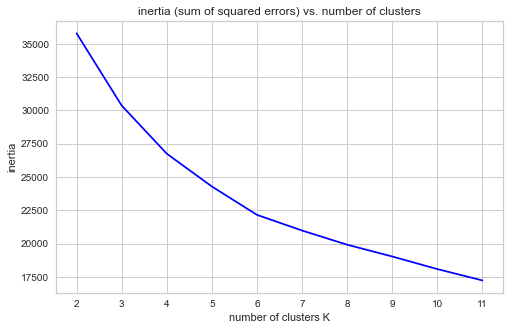

In [53]:
# kmeans: looking for the elbow - compare number of clusters by their inertia scores

# run kMeans for alternative number of clusters k
inertia_scores = [KMeans(
                    n_clusters=k, 
                    init='k-means++', 
                    n_init=10, max_iter=100, random_state=RNDN). \
                    fit(dfa3).inertia_ \
                    for k in range(2,nK)]


dict_inertia = dict(zip(range(2,nK), inertia_scores))
print("inertia scores (sum of squared errors) by number of clusters:")
_ = [print(k, ":", f'{v:,.0f}') for k,v in dict_inertia.items()]

# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(range(2,nK), inertia_scores, color="blue")
plt.title("inertia (sum of squared errors) vs. number of clusters")
plt.xticks(np.arange(2,nK,1.0))
plt.xlabel("number of clusters K")
plt.ylabel("inertia");

In [54]:
# inertia scores: confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
inertia_knee_a3 = KneeLocator(
        range(2,nK), 
        inertia_scores, 
        S=0.1, curve="convex", direction="decreasing")

K_inertia_a3 = inertia_knee_a3.elbow   
print("elbow at k =", f'{K_inertia_a3:.0f} clusters')

elbow at k = 6 clusters


In [55]:
# kMeans: silhouette score
# initial example: silhouette score for 4 clusters
k = 4
model = KMeans(n_clusters=k, random_state=RNDN, verbose=0)
clusters_assigned = model.fit_predict(dfa3)
K_sil_a3 = silhouette_score(dfa3, clusters_assigned)
print("silhouette score for", k, "clusters: " f'{K_sil_a3:.3f}')

silhouette score for 4 clusters: 0.211


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

silhouette scores:
2 : 0.208
3 : 0.221
4 : 0.211
5 : 0.223
6 : 0.228
7 : 0.209
8 : 0.206
9 : 0.205
10 : 0.206
11 : 0.205
maximum silhouette score for 6 clusters:  0.228


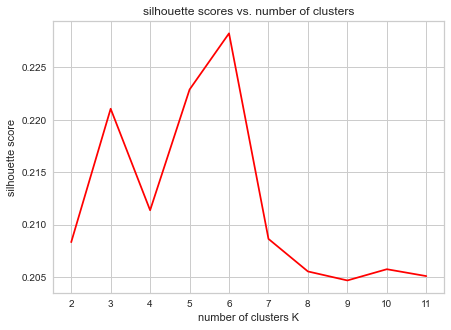

In [56]:
# find maximum silhouette score for up to kN clusters
sil_scores = [silhouette_score(
                                dfa3, 
                                KMeans(n_clusters=k, random_state=RNDN). \
                                fit_predict(dfa3)) \
                                for k in tqdm(range(2,nK))]

dict_sil = dict(zip(range(2,nK), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_a3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,nK), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters")
plt.xticks(np.arange(2,nK,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()

100%|██████████| 10/10 [00:22<00:00,  2.30s/it]


silhouette scores for k clusters:
2 : 0.208
3 : 0.221
4 : 0.211
5 : 0.223
6 : 0.228
7 : 0.209
8 : 0.206
9 : 0.205
10 : 0.206
11 : 0.205
maximum silhouette score for 6 clusters:  0.228


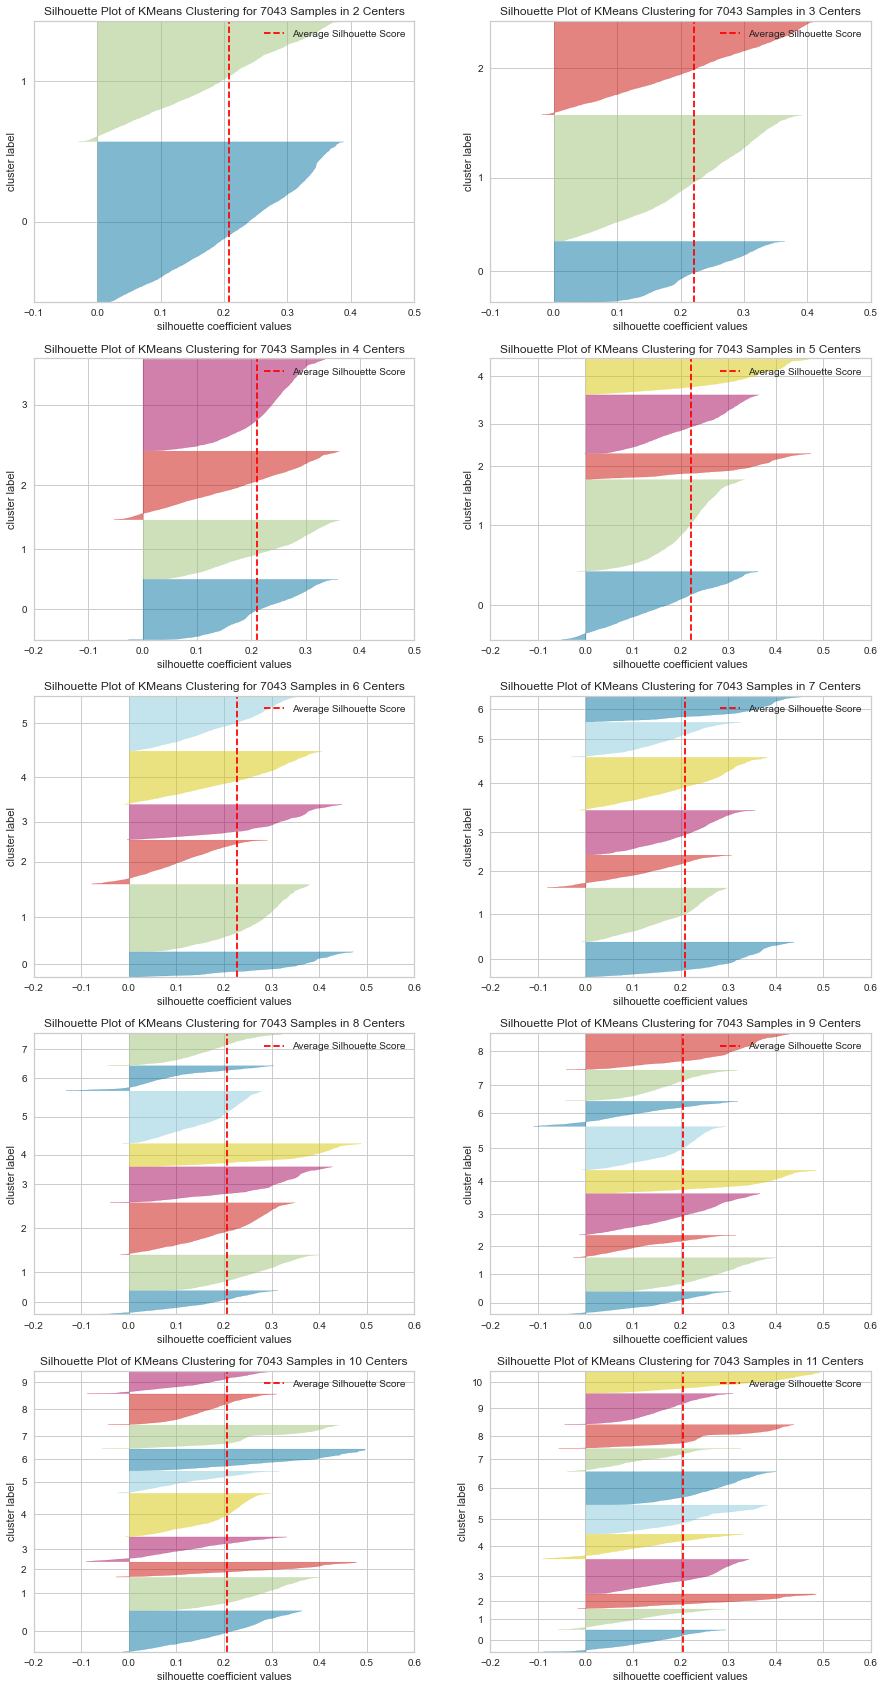

In [57]:
# silhouette score plots with Yellowbrick
dict_score = dict()
fig, ax = plt.subplots(int(np.ceil(nK/2)-1), 2, figsize=(15,30))

for i in tqdm(range(2,nK)):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
    
    q, mod = divmod(i, 2)
    vis = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod], is_fitted=False)
    vis.fit(dfa3)
    vis.finalize()
    dict_score[i] = vis.silhouette_score_


print("silhouette scores for k clusters:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_score.items()]

K_sil_a3 = max(dict_score, key=dict_score.get)          # optimal clusters
sil_opt_a3 = dict_score[K_sil_a3]                       # optimal (maximal) silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

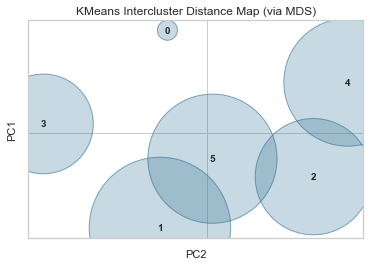

In [58]:
# optimal number of clusters: intercluster distances
model = KMeans(
    n_clusters=K_sil_a3, init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
visD = InterclusterDistance(
    model, max_size=20000, legend=False, random_state=RNDN)
visD.fit(dfa3)
visD.finalize()

100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


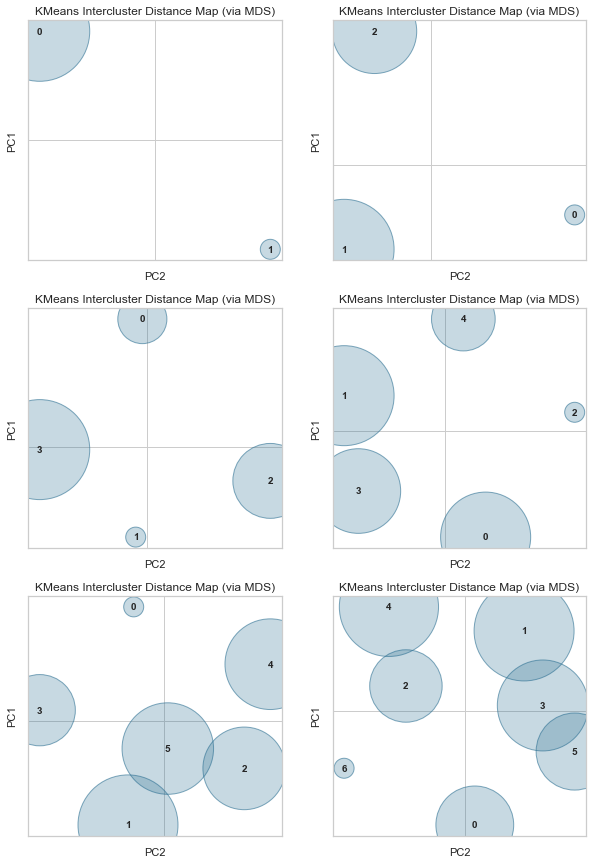

In [59]:
# intercluster distance maps: alternative numbers of clusters
dict_score = dict()
nK = 8
fig, ax = plt.subplots(int(np.ceil(nK/2))-1, 2, figsize=(10,15))

for i in tqdm(range(2,nK)):
    km = KMeans(
                n_clusters=i, 
                init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
    
    q, mod = divmod(i, 2)
    vis = InterclusterDistance(
        km, ax=ax[q-1][mod], max_size=10000, legend=False, random_state=RNDN)
    vis.fit(dfa3)
    vis.finalize()
    dict_score[i] = vis.scores_

In [60]:
# %split training vs test dataset
df_train, df_test = train_test_split(dfa3, train_size=frTRAIN, random_state=RNDN)

In [61]:
# training: generate "Cluster" column based on optimal number of clusters
model = KMeans(n_clusters=K_sil_a3, random_state=RNDN)
res = model.fit_predict(df_train)
df_train.insert(0, "Cluster", res)     # insert cluster labels as new column
df_train.tail()

,Cluster,tenure,MonthlyCharges,gender_n,Partner_n,Dependents_n,PhoneService_n,InternetService_n,StreamingTV_n,Contract_n,PaperlessBilling_n,PaymentMethod_n,Churn_n,SeniorCitizen_n
3772,3,-1.277,1.005,1,1,0,1,1,2,0,1,2,1,0
5191,0,-0.382,0.875,0,1,1,1,0,2,2,1,1,0,0
5226,2,-0.830,-1.449,1,1,1,1,2,1,0,1,2,0,0
5390,3,-0.830,1.153,1,0,0,1,1,2,0,1,2,1,1
860,5,-0.259,-1.494,1,0,0,1,2,1,1,0,1,0,0


In [62]:
# training: get silhouette score
sil_train = silhouette_score(df_train, res)
print("training: silhouette score for", f'{K_sil_a3:.0f} clusters: {sil_train:.3f}')

training: silhouette score for 6 clusters: 0.331


In [63]:
# testing: generate "Cluster" column based on optimal number of clusters
pred = model.fit_predict(df_test)
sil_test = silhouette_score(df_test, pred)
print("testing: silhouette score for", \
    f'{K_sil_a3:.0f} clusters: {sil_test:.3f}. Variance vs training: {(sil_test / sil_train -1)*100:.1f}%')
df_test.insert(0, "Cluster", pred)  

testing: silhouette score for 6 clusters: 0.238. Variance vs training: -28.0%


In [64]:
# insert Cluster column in original dataframe
dfa1["Cluster"] = pd.concat([df_train["Cluster"], df_test["Cluster"]], axis=0)
dfa1 = dfa1.sort_values("Cluster")
print(dfa1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 7042 to 4593
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   float64
 5   PhoneService      7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   StreamingTV       7043 non-null   object 
 8   Contract          7043 non-null   object 
 9   PaperlessBilling  7043 non-null   object 
 10  PaymentMethod     7043 non-null   object 
 11  MonthlyCharges    7043 non-null   float64
 12  Churn             7043 non-null   object 
 13  SeniorCitizen     7043 non-null   object 
 14  Cluster           7043 non-null   int32  
dtypes: float64(2), int32(1), object(12)
memory usage: 852.9+ KB
None


In [65]:
# size of clusters
dfgrp = dfa1.groupby("Cluster").count()
dfgrp["Contract"]

Cluster
0    1304
1    1261
2     984
3    1222
4    1515
5     757
Name: Contract, dtype: int64

In [66]:
pd.crosstab(dfa1["Cluster"],
            dfa1["Churn"],
            values=dfa1["MonthlyCharges"],
            aggfunc="mean",
            normalize=False)

Churn,No,Yes
Cluster,,
0,87.316,94.907
1,66.903,68.755
2,31.758,65.024
3,71.028,88.386
4,53.154,64.533
5,44.257,62.700


In [67]:
pd.crosstab(dfa1["Cluster"],
            dfa1["StreamingTV"],
            values=dfa1["StreamingTV"],
            aggfunc="count",
            normalize=False)

StreamingTV,No,No internet service,Yes
Cluster,,,
0,215.000,NaN,1089.000
1,1258.000,NaN,3.000
2,NaN,708.000,276.000
3,NaN,134.000,1088.000
4,1337.000,178.000,NaN
5,NaN,506.000,251.000


In [68]:
# most frequent column values for each cluster
dfa1.groupby(["Cluster"]).agg(lambda x:x.value_counts().index[0])

,customerID,gender,Partner,Dependents,tenure,PhoneService,InternetService,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,SeniorCitizen
Cluster,,,,,,,,,,,,,,
0,3186-AJIEK,Female,Yes,No,72.000,Yes,Fiber optic,Yes,Two year,Yes,Bank transfer (automatic),105.250,No,0
1,8871-JLMHM,Male,No,No,1.000,Yes,DSL,No,Month-to-month,Yes,Bank transfer (automatic),74.400,No,0
2,3898-GUYTS,Male,No,No,1.000,Yes,No,No internet service,Month-to-month,No,Mailed check,20.050,No,0
3,3657-COGMW,Male,No,No,1.000,Yes,Fiber optic,Yes,Month-to-month,Yes,Electronic check,19.650,No,0
4,2498-XLDZR,Male,No,No,1.000,Yes,DSL,No,Month-to-month,Yes,Electronic check,19.900,No,0
5,0936-NQLJU,Male,Yes,No,72.000,Yes,No,No internet service,Two year,No,Bank transfer (automatic),20.050,No,0


In [69]:
# helper function: pie charts for categorical variables
def cluster_pies(df):
    
    # number of categorical variables
    c = len(df.select_dtypes("object").nunique())
    
    # number of clusters
    K = df["Cluster"].nunique()

    for k in tqdm(range(K)):
        dfc = df[df["Cluster"]==k]
        chrg = dfc["MonthlyCharges"].median()
        ten = dfc["tenure"].median()
        cases = dfc.shape[0]

        fig = plt.figure(figsize=(50, 12))
        fig.suptitle("Cluster " + str(k) + ": " + \
            f'{cases:,.0f}' + " cases | " + \
            "median charge " + f'{chrg:.2f}' + \
            " | median tenure " + f'{ten:.0f}')


        ax1 = plt.subplot2grid((2,c),(0,0))
        plt.pie(dfc["Contract"].value_counts(), labels=dfc["Contract"].unique())
        plt.title("Contract");

        ax1 = plt.subplot2grid((2,c),(0,1))
        plt.pie(dfc["gender"].value_counts(), labels=dfc["gender"].unique())
        plt.title("gender");

        ax1 = plt.subplot2grid((2,c),(0,2))
        plt.pie(dfc["SeniorCitizen"].value_counts(), labels=dfc["SeniorCitizen"].unique())
        plt.title("SeniorCitizen");

        ax1 = plt.subplot2grid((2,c),(0,3))
        plt.pie(dfc["Partner"].value_counts(), labels=dfc["Partner"].unique())
        plt.title("Partner");

        ax1 = plt.subplot2grid((2,c),(0,4))
        plt.pie(dfc["PhoneService"].value_counts(), labels=dfc["PhoneService"].unique())
        plt.title("PhoneService");

        ax1 = plt.subplot2grid((2,c),(0,5))
        plt.pie(dfc["InternetService"].value_counts(), labels=dfc["InternetService"].unique())
        plt.title("InternetService");

        ax1 = plt.subplot2grid((2,c),(0,6))
        plt.pie(dfc["StreamingTV"].value_counts(), labels=dfc["StreamingTV"].unique())
        plt.title("StreamingTV");

In [70]:
# helper function: medians and modes for each cluster
def cluster_profile(df):
    dfc = df.groupby("Cluster").agg({ 
        "MonthlyCharges": "median",
        "Contract": lambda x: x.value_counts().index[0],
        "tenure": "median",
        "gender": lambda x: x.value_counts().index[0],
        "SeniorCitizen": lambda x: x.value_counts().index[0],
        "Partner": lambda x: x.value_counts().index[0],
        "Dependents": lambda x: x.value_counts().index[0],
        "PhoneService": lambda x: x.value_counts().index[0],
        "InternetService": lambda x: x.value_counts().index[0],
        "StreamingTV": lambda x: x.value_counts().index[0],
        "PaperlessBilling": lambda x: x.value_counts().index[0],
        "PaymentMethod": lambda x: x.value_counts().index[0],
        "Churn": lambda x: x.value_counts().index[0]
                                    })    #.sort_values(by=["MonthlyCharges"], ascending=False)

    cluster_pies(df)
    return dfc

100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


Cluster,0,1,2,3,4,5
MonthlyCharges,90.875,70.250,20.450,89.000,59.450,24.400
Contract,Two year,Month-to-month,Month-to-month,Month-to-month,Month-to-month,Two year
tenure,62.000,32.000,15.000,22.000,8.000,56.000
gender,Female,Male,Male,Male,Male,Male
SeniorCitizen,0,0,0,0,0,0
Partner,Yes,No,No,No,No,Yes
Dependents,No,No,No,No,No,No
PhoneService,Yes,Yes,Yes,Yes,Yes,Yes
InternetService,Fiber optic,DSL,No,Fiber optic,DSL,No
StreamingTV,Yes,No,No internet service,Yes,No,No internet service


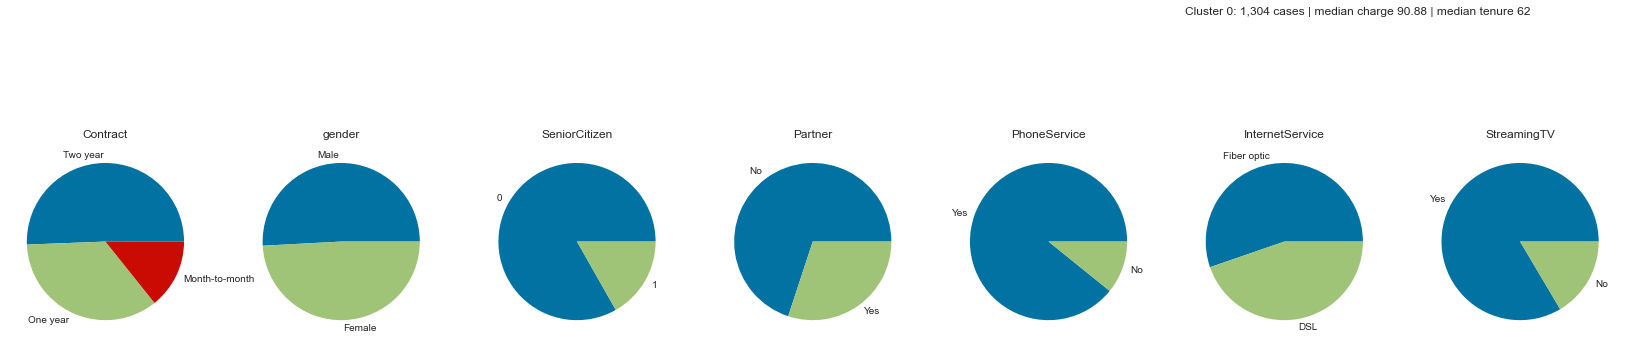

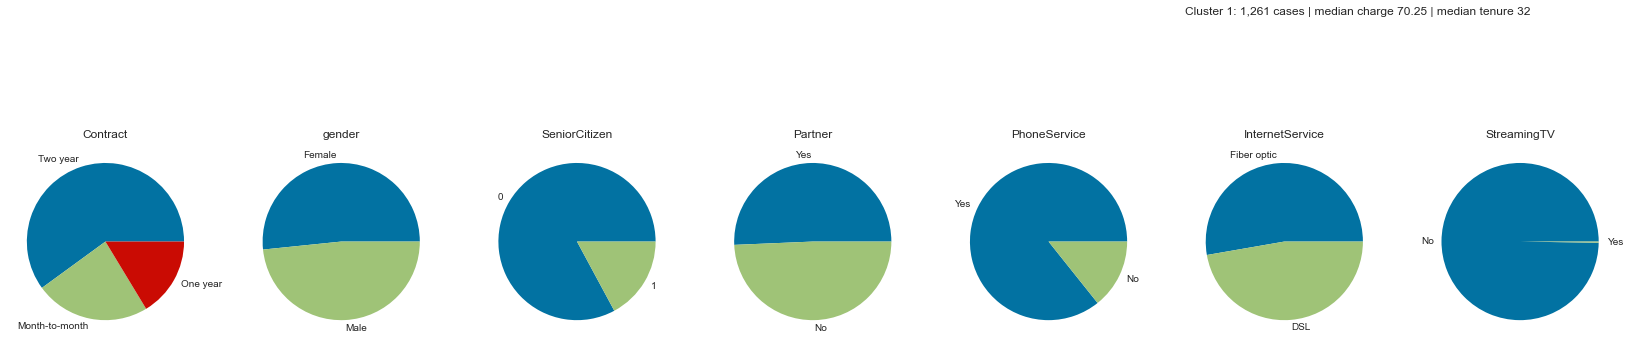

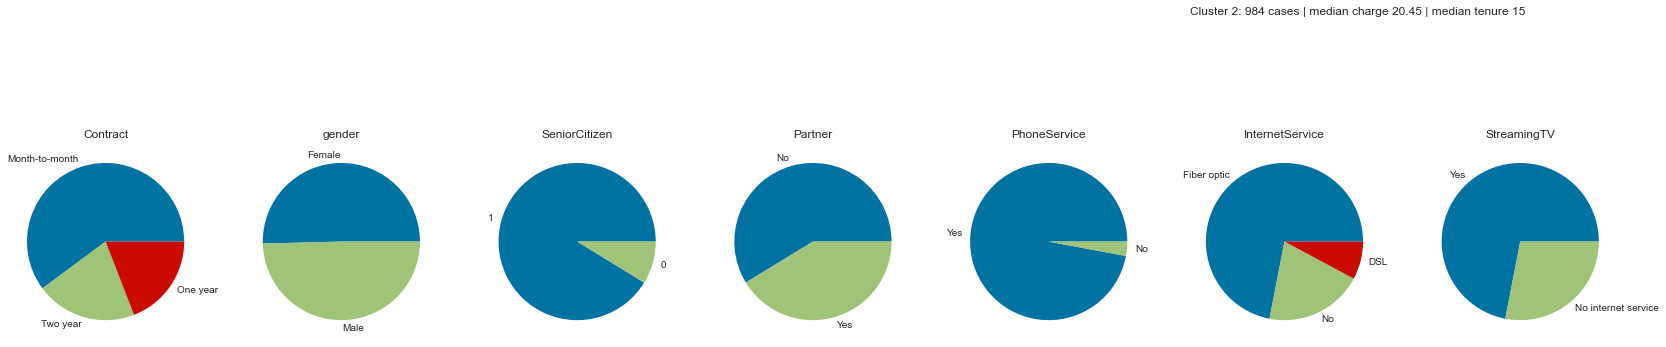

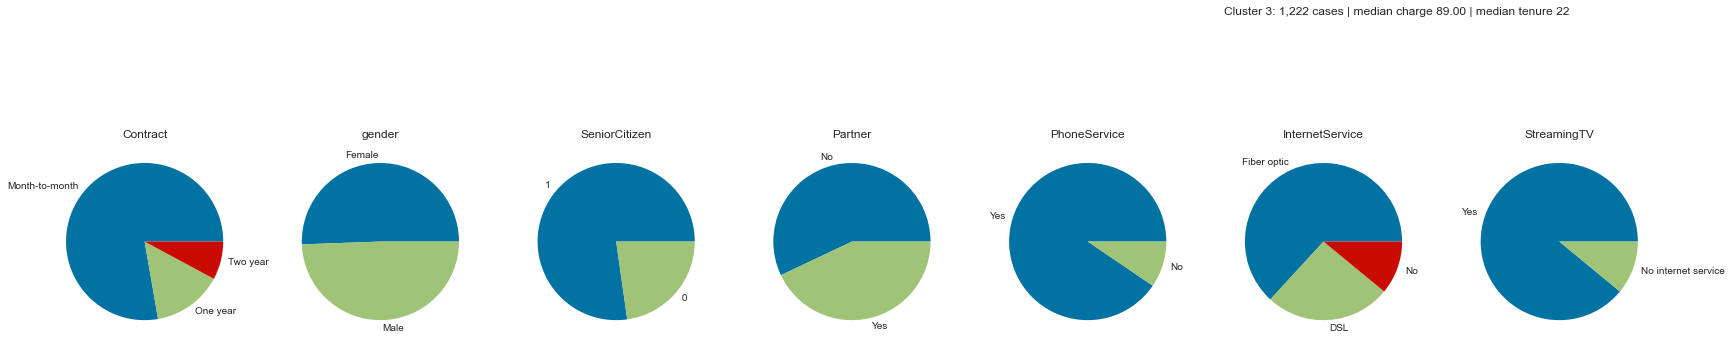

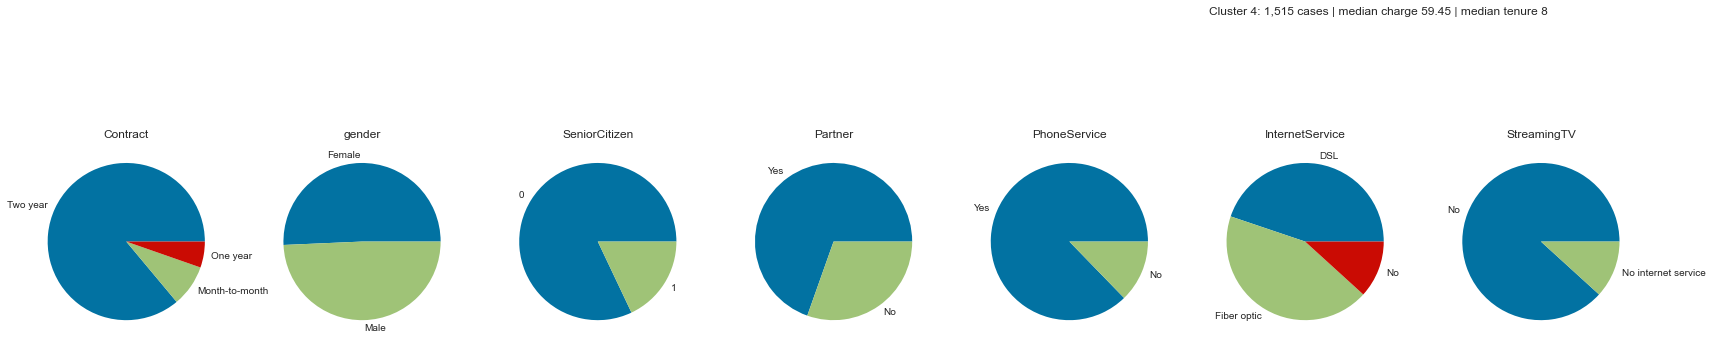

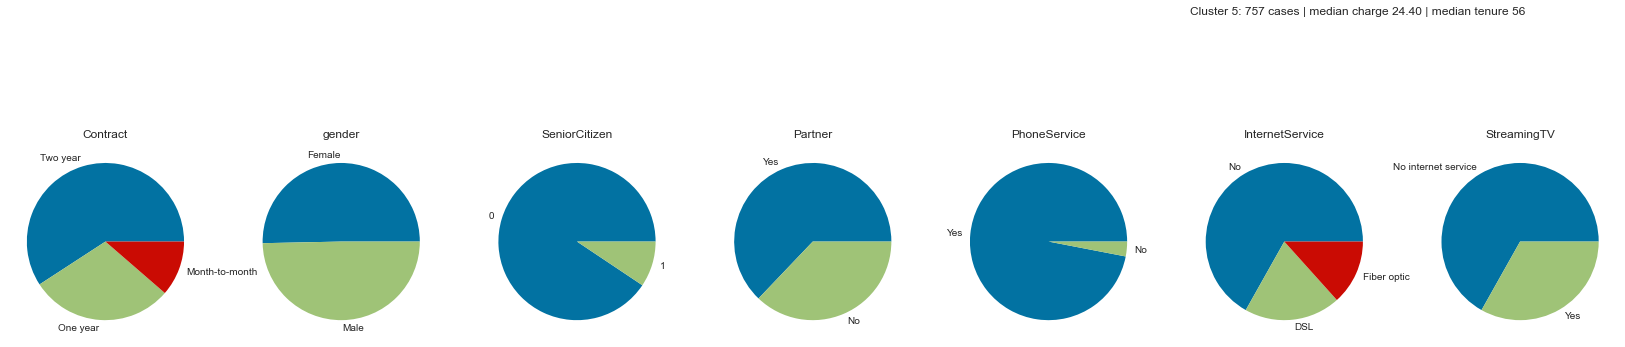

In [71]:
# call cluster profile function
cluster_profile(dfa1).T

# A.2 Translate Categories to Numerical Variables - Mean Shift

bandwidth estimated by sklearn: 2.03
number of clusters:  6
silhouette score of Mean Shift model 0.274


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Cluster,0,1,2,3,4
MonthlyCharges,69.150,91.050,90.650,20.050,20.550
Contract,Month-to-month,Month-to-month,Two year,Month-to-month,Two year
tenure,12.000,21.000,65.000,12.000,53.000
gender,Male,Female,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,No,No,Yes,No,Yes
Dependents,No,No,No,No,No
PhoneService,Yes,Yes,Yes,Yes,Yes
InternetService,DSL,Fiber optic,Fiber optic,No,No
StreamingTV,No,Yes,Yes,No internet service,No internet service


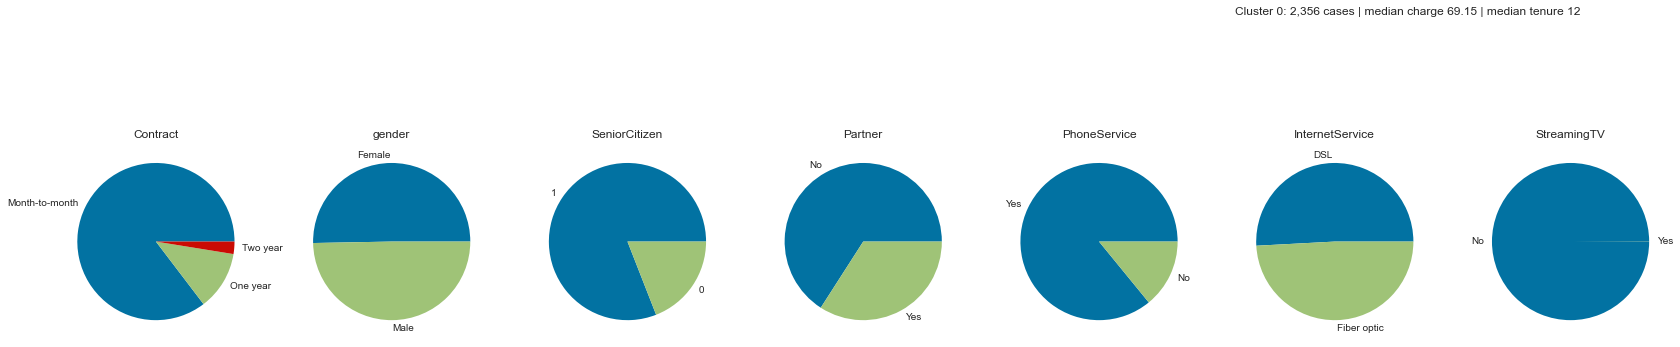

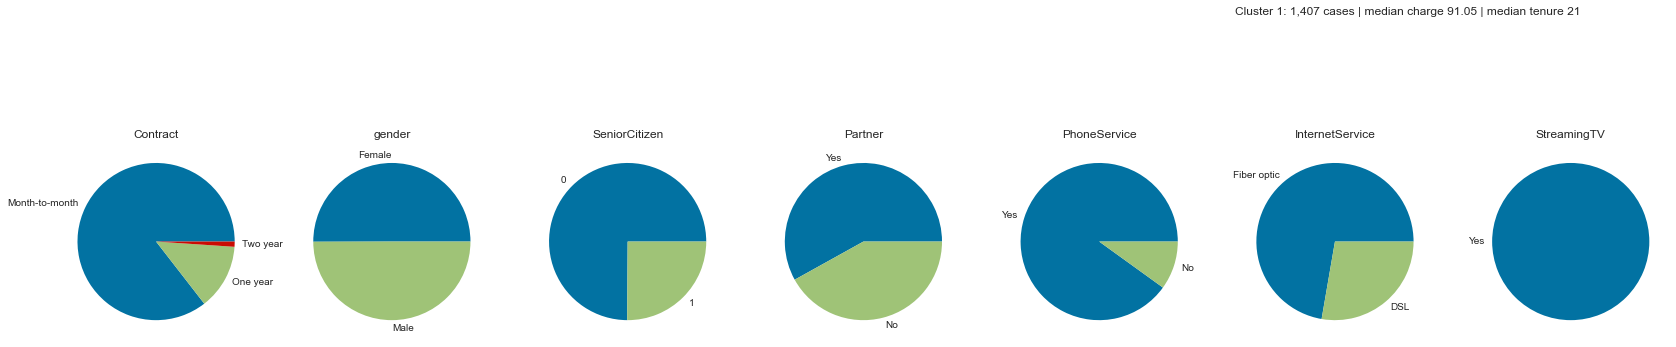

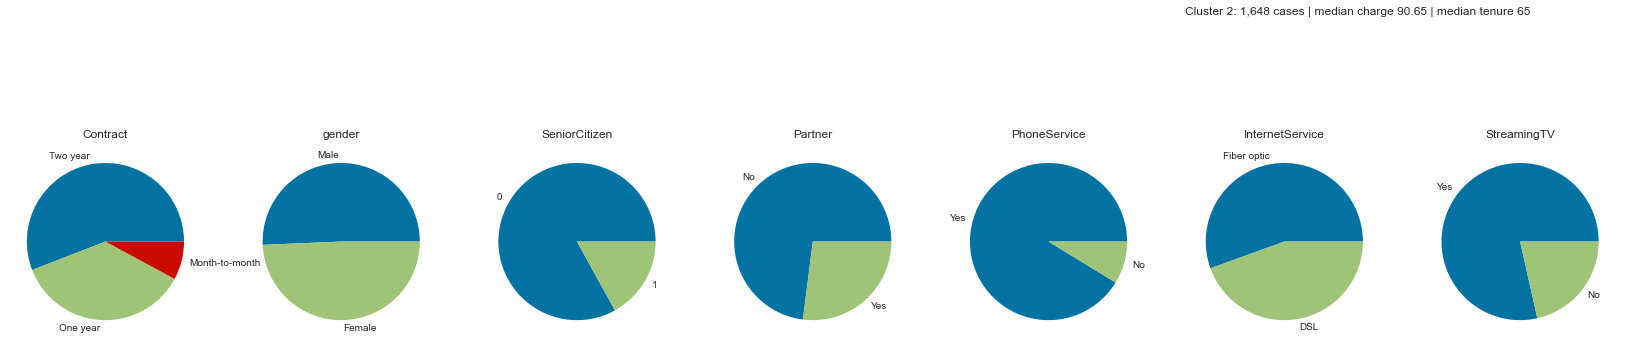

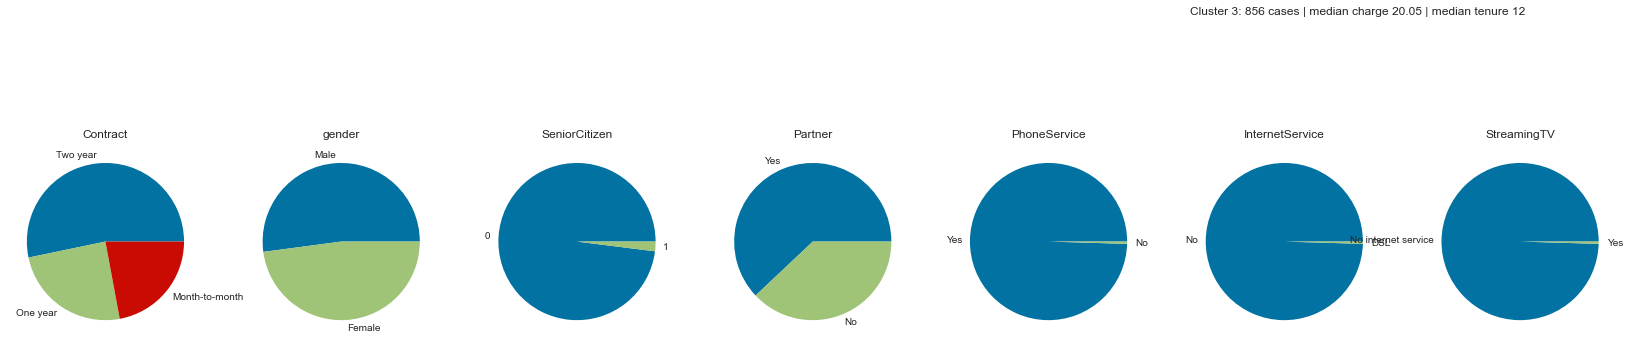

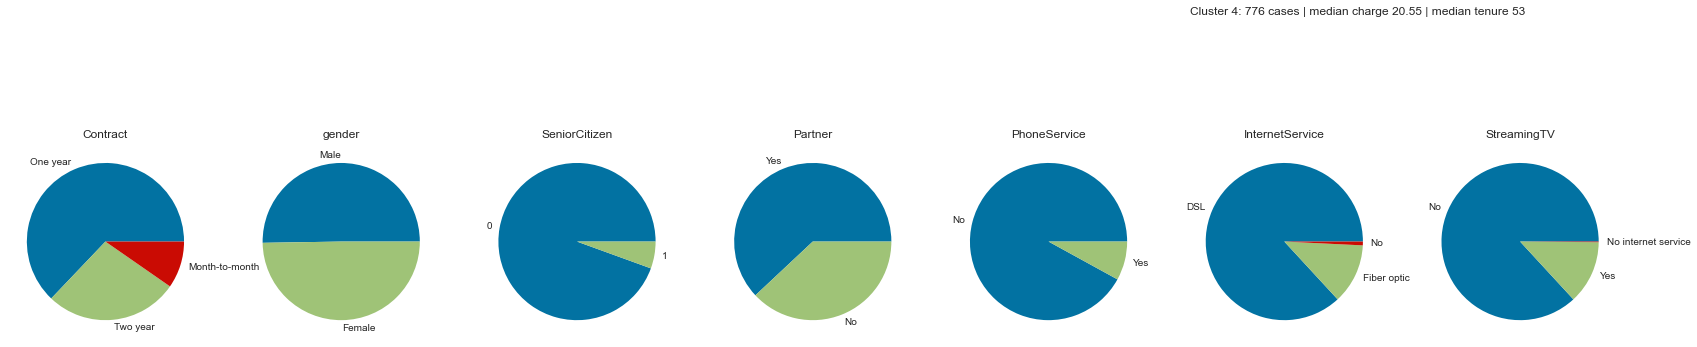

In [72]:
dfd3 = dfa3.copy()
dfd1 = dfa1.copy()

# mean shift clustering
bw = estimate_bandwidth(dfd3, quantile=0.05)
print("bandwidth estimated by sklearn:", f'{bw:.2f}')
model = MeanShift(bandwidth=bw, bin_seeding=True)
model.fit(dfd3)

dfd3["Cluster"]= model.predict(dfd3)
c = dfd1.Cluster.nunique()
print("number of clusters: ", f'{c:.0f}')

sil_ms = silhouette_score(dfd3, dfd3["Cluster"])
print("silhouette score of Mean Shift model", f'{sil_ms:.3f}')

dfd1["Cluster"] = dfd3["Cluster"]

# call cluster profile function
cluster_profile(dfd1).T

# B. One-Hot Encoding of Category Variables

In [73]:
dfb1 = dfa0.copy()
dfb1.tail(2)

,customerID,gender,Partner,Dependents,tenure,PhoneService,InternetService,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,SeniorCitizen
7041,8361-LTMKD,Male,Yes,No,4,Yes,Fiber optic,No,Month-to-month,Yes,Mailed check,74.400,Yes,1
7042,3186-AJIEK,Male,No,No,66,Yes,Fiber optic,Yes,Two year,Yes,Bank transfer (automatic),105.650,No,0


In [74]:
# one-hot encoding: generate dummy variables from category variables
# transform and scale numerical variables
dfb2 = dfb1.copy()
dfb2.drop("customerID", axis=1, inplace=True)

df_num = dfb2.select_dtypes(exclude='object')
df_cat = dfb2.select_dtypes(include='object')

for c in df_num.columns:
    pt = PowerTransformer()
    df_num.loc[:, c] = pt.fit_transform(np.array(df_num[c]).reshape(-1, 1))

# one-hot encoding
df_cat = pd.get_dummies(df_cat)
df_cat

# combine scaled numerical and categorical dummy variables in a dataframe
dfb2 = pd.concat([df_num, df_cat], axis=1)
dfb2

,tenure,MonthlyCharges,SeniorCitizen,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,-1.644,-1.159,-0.440,1,0,0,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
1,0.297,-0.239,-0.440,0,1,1,0,1,0,0,...,1,0,1,0,0,0,0,1,1,0
2,-1.495,-0.343,-0.440,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
3,0.646,-0.731,-0.440,0,1,1,0,1,0,1,...,1,0,1,0,1,0,0,0,1,0
4,-1.495,0.214,-0.440,1,0,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.078,0.672,-0.440,0,1,0,1,0,1,0,...,1,0,0,1,0,0,0,1,1,0
7039,1.342,1.261,-0.440,1,0,0,1,0,1,0,...,1,0,0,1,0,1,0,0,1,0
7040,-0.725,-1.167,-0.440,1,0,0,1,0,1,1,...,0,0,0,1,0,0,1,0,1,0
7041,-1.265,0.334,2.273,0,1,0,1,1,0,0,...,0,0,0,1,0,0,0,1,0,1


In [75]:
# Standardize the data to have a mean of ~0 and a variance of 1
dfb3 = dfb2.copy()
dfb3 = StandardScaler().fit_transform(dfb3)

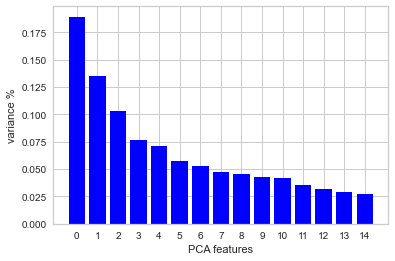

In [76]:
# principal components
pca = PCA(n_components=15)
res_pca = pca.fit_transform(dfb3)

# scree plot: variance drop-off after the fifth component; first 5 explain most of variance in data
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

df_pca = pd.DataFrame(res_pca)

Text(0, 0.5, 'PCA 2')

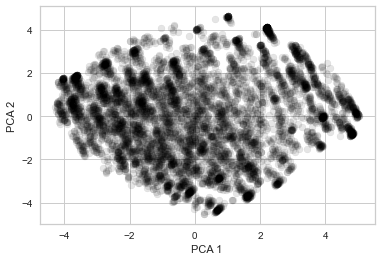

In [77]:
# plot first 2 components to see if there are any clear clusters
plt.scatter(df_pca[0], df_pca[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

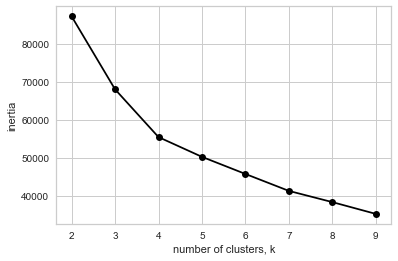

In [78]:
# kMeans with PCA components
ks = range(2, 10)
inertias_pca = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_pca.iloc[:,:5])
    
    # Append the inertia to the list of inertias
    inertias_pca.append(model.inertia_)
    
plt.plot(ks, inertias_pca, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [79]:
# inertia scores: confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
inertia_knee_b3 = KneeLocator(
        range(2,10), 
        inertias_pca, 
        S=0.1, curve="convex", direction="decreasing")

K_inertia_b3 = inertia_knee_b3.elbow   
print("elbow at k =", f'{K_inertia_b3:.0f} clusters')

elbow at k = 4 clusters


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]

silhouette scores:
2 : 0.166
3 : 0.167
4 : 0.172
5 : 0.156
6 : 0.150
7 : 0.145
8 : 0.136
9 : 0.135
maximum silhouette score for 4 clusters:  0.172


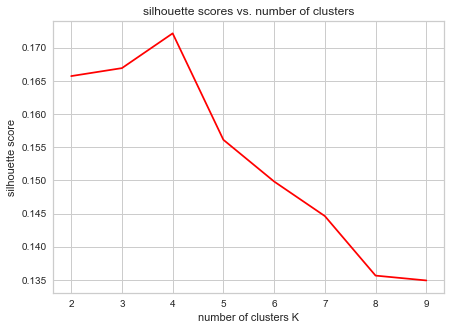

In [80]:
# find maximum silhouette score for up to 10 clusters
sil_scores = [silhouette_score(
                                dfb3, 
                                KMeans(n_clusters=k, random_state=RNDN). \
                                fit_predict(dfb3)) \
                                for k in tqdm(range(2,10))]

dict_sil = dict(zip(range(2,10), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_b3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_b3 = dict_sil[K_sil_b3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_b3:.0f} clusters: ', f'{sil_opt_b3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,10), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()

In [81]:
# kMeans with clusters determined by elbow method
model = KMeans(n_clusters=K_inertia_b3, random_state=RNDN)
clusters = model.fit_predict(dfb3)
dfb1.insert(0, "Cluster", clusters)  
dfb1.tail(2)

,Cluster,customerID,gender,Partner,Dependents,tenure,PhoneService,InternetService,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,SeniorCitizen
7041,3,8361-LTMKD,Male,Yes,No,4,Yes,Fiber optic,No,Month-to-month,Yes,Mailed check,74.400,Yes,1
7042,1,3186-AJIEK,Male,No,No,66,Yes,Fiber optic,Yes,Two year,Yes,Bank transfer (automatic),105.650,No,0


100%|██████████| 4/4 [00:00<00:00,  6.45it/s]


Cluster,0,1,2,3
MonthlyCharges,40.575,86.100,20.150,79.850
Contract,Month-to-month,One year,Two year,Month-to-month
tenure,29.000,55.000,25.000,11.000
gender,Male,Female,Male,Male
SeniorCitizen,0,0,0,0
Partner,No,Yes,No,No
Dependents,No,No,No,No
PhoneService,No,Yes,Yes,Yes
InternetService,DSL,Fiber optic,No,Fiber optic
StreamingTV,No,Yes,No internet service,No


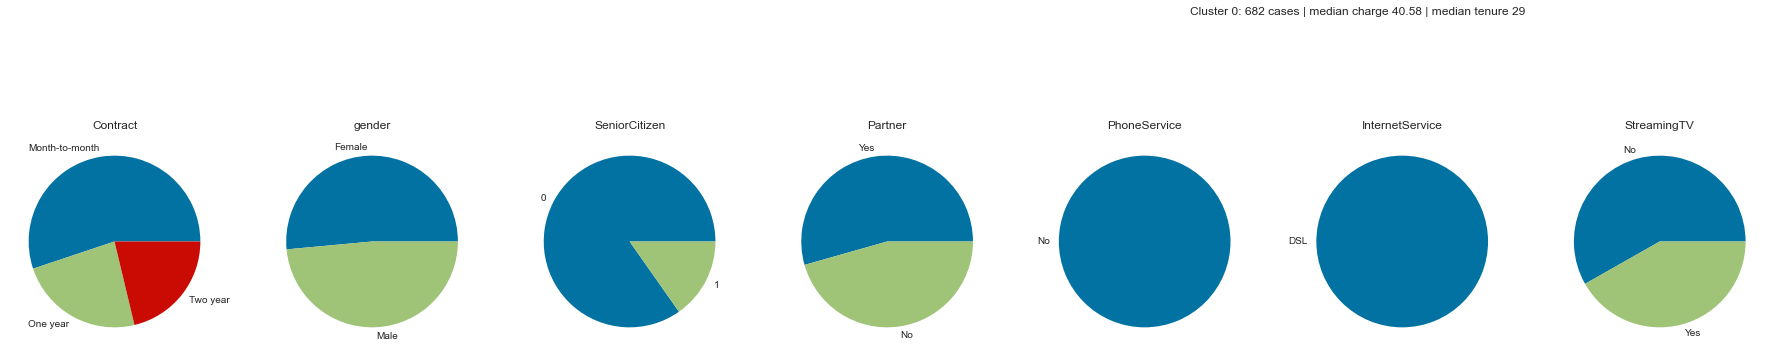

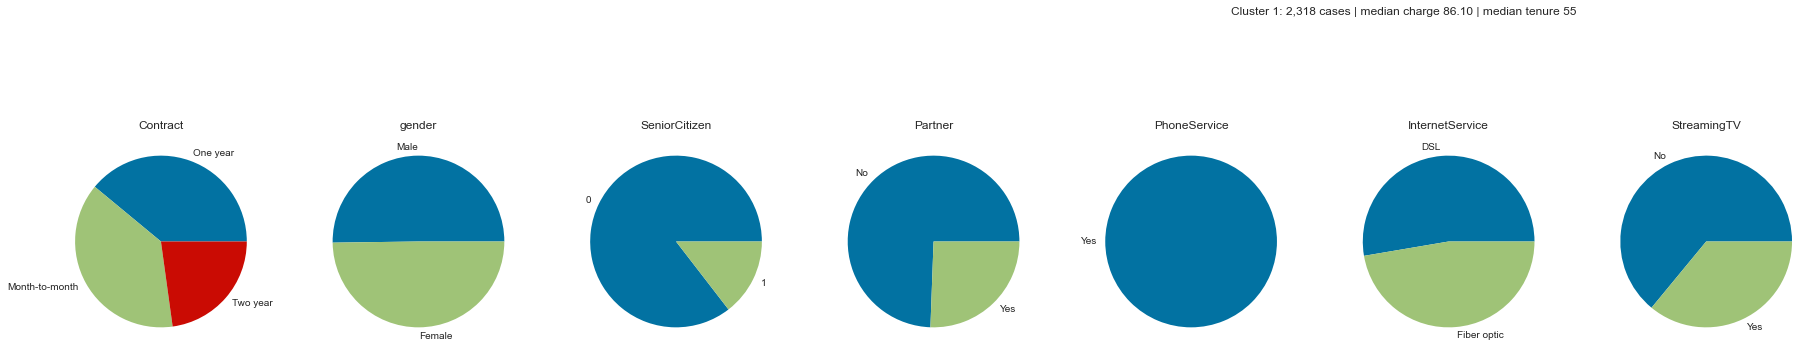

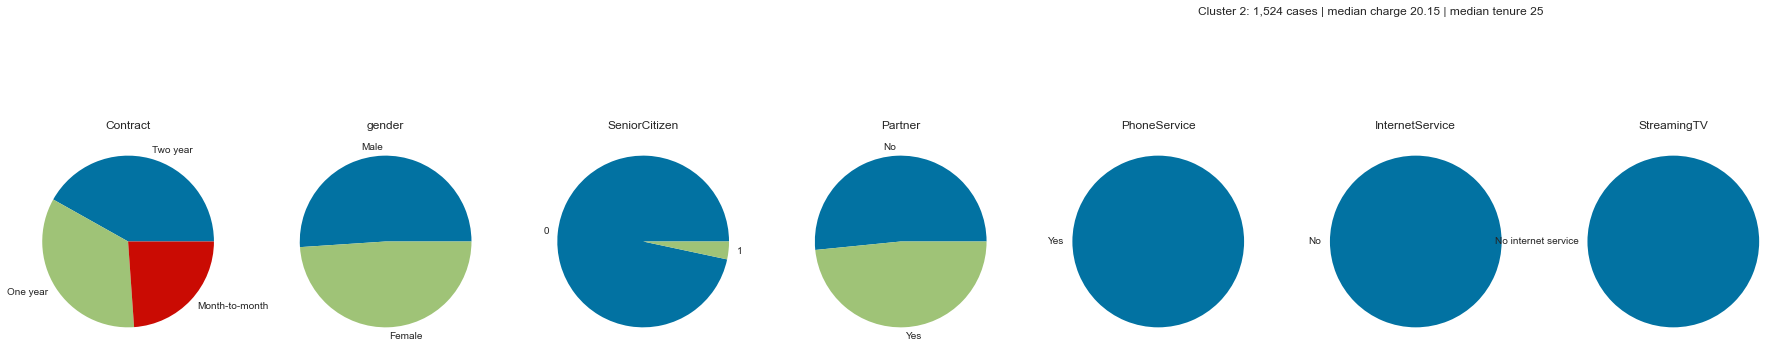

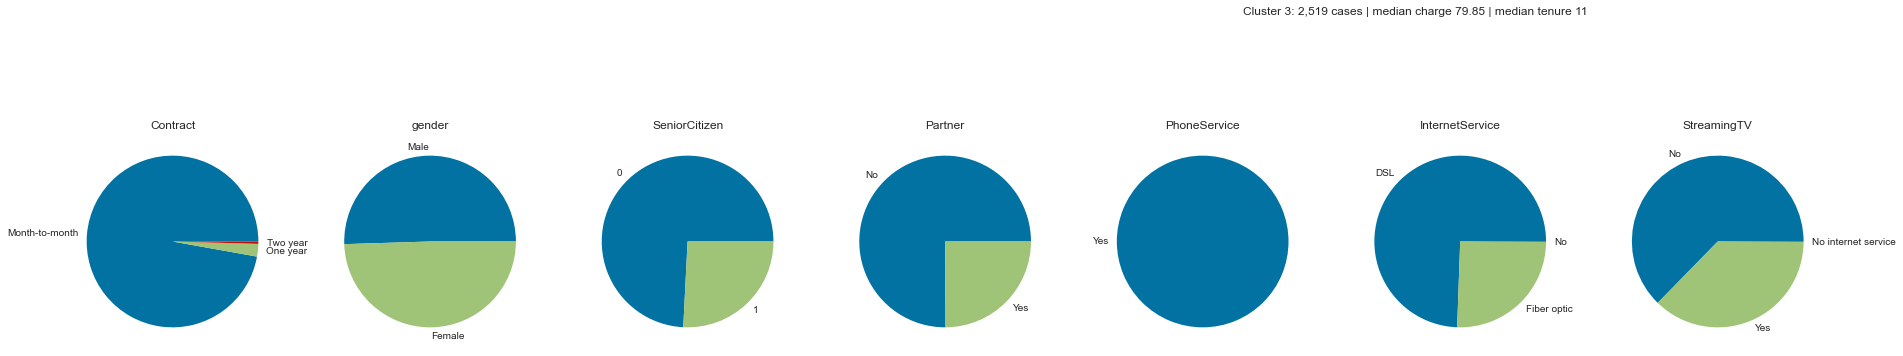

In [82]:
# call cluster profile function
cluster_profile(dfb1).T

# C. k-Prototyping for Mixed Numerical and Categorical Variables

In [83]:
dfc1 = dfa0.copy()
dfc1.tail(2)

,customerID,gender,Partner,Dependents,tenure,PhoneService,InternetService,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,SeniorCitizen
7041,8361-LTMKD,Male,Yes,No,4,Yes,Fiber optic,No,Month-to-month,Yes,Mailed check,74.400,Yes,1
7042,3186-AJIEK,Male,No,No,66,Yes,Fiber optic,Yes,Two year,Yes,Bank transfer (automatic),105.650,No,0


In [84]:
dfc2 = dfc1.copy()
dfc2.drop("customerID", axis=1, inplace=True)   # drop customerID, meaningless for clustering

# type conversions
dfc2["tenure"] = dfc2["tenure"].astype(np.float64)
dfc2["SeniorCitizen"] = dfc2["SeniorCitizen"].astype(object)

In [85]:
# scale the numerical variables
dfc3 = dfc2.copy()
numcols = list(dfc3.dtypes[dfc3.dtypes == "float64"].index)
print(numcols)
scaler = StandardScaler()
dfc3[numcols] = scaler.fit_transform(dfc3[numcols])
dfc3.describe()

['tenure', 'MonthlyCharges']


,tenure,MonthlyCharges
count,7043.000,7043.000
mean,-0.000,-0.000
std,1.000,1.000
min,-1.318,-1.546
25%,-0.952,-0.973
50%,-0.137,0.186
75%,0.921,0.834
max,1.614,1.794


In [86]:
# get indices of category columns
catcol_idx = [dfc3.columns.get_loc(col) for col in list(dfc3.select_dtypes("object").columns)]
catcol_idx

[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12]

In [87]:
# kPrototypes
kproto4 = KPrototypes(n_clusters = 4, init='Cao', n_jobs = 4)
res4 = kproto4.fit_predict(dfc3, categorical=catcol_idx)
kproto4.cost_

15164.410412806155

  0%|          | 0/8 [00:00<?, ?it/s]

Best run was number 1


 12%|█▎        | 1/8 [00:23<02:41, 23.07s/it]

Best run was number 2


 25%|██▌       | 2/8 [00:57<02:57, 29.54s/it]

Best run was number 8


 38%|███▊      | 3/8 [01:34<02:46, 33.26s/it]

Best run was number 1


 50%|█████     | 4/8 [02:16<02:26, 36.51s/it]

Best run was number 2


 62%|██████▎   | 5/8 [03:00<01:57, 39.15s/it]

Best run was number 5


 75%|███████▌  | 6/8 [03:57<01:30, 45.50s/it]

Best run was number 7


 88%|████████▊ | 7/8 [04:58<00:50, 50.50s/it]

Best run was number 9


100%|██████████| 8/8 [05:56<00:00, 44.60s/it]

cost (sum distance) for all k:
2 : 21895.403
3 : 17243.833
4 : 15156.524
5 : 13826.764
6 : 12861.264
7 : 12185.757
8 : 11810.900
9 : 11333.800


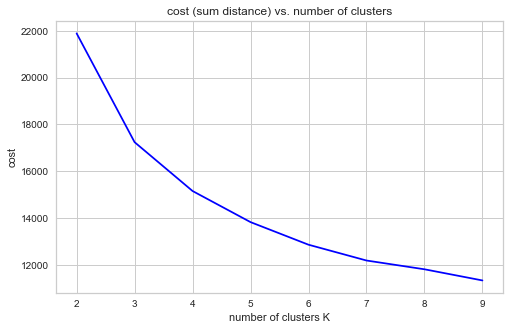

In [88]:
# kprototypes: looking for the elbow - compare number of clusters by their cost
# cost = sum distance of all points to their respective cluster centroids

# run kPrototypes for alternative number of clusters k
dict_cost_c3 = {}
for k in tqdm(range(2,10)):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_jobs=4, verbose=2)
    res = kproto.fit_predict(dfc3, categorical=catcol_idx)
    dict_cost_c3[k] = kproto.cost_

print("cost (sum distance) for all k:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_cost_c3.items()]


# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(dict_cost_c3.keys(), dict_cost_c3.values(), color="blue")
plt.title("cost (sum distance) vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("cost");

In [89]:
# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
cost_knee_c3 = KneeLocator(
        x=list(dict_cost_c3.keys()), 
        y=list(dict_cost_c3.values()), 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 4 clusters


In [90]:
# kPrototypes with clusters determined by elbow method
dfc1.insert(0, "Cluster", res4)  
dfc1.tail(2)

,Cluster,customerID,gender,Partner,Dependents,tenure,PhoneService,InternetService,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,SeniorCitizen
7041,2,8361-LTMKD,Male,Yes,No,4,Yes,Fiber optic,No,Month-to-month,Yes,Mailed check,74.400,Yes,1
7042,1,3186-AJIEK,Male,No,No,66,Yes,Fiber optic,Yes,Two year,Yes,Bank transfer (automatic),105.650,No,0


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Cluster,0,1,2,3
MonthlyCharges,40.350,92.400,82.000,20.750
Contract,Month-to-month,Two year,Month-to-month,Two year
tenure,8.000,61.000,12.000,51.000
gender,Male,Male,Female,Female
SeniorCitizen,0,0,0,0
Partner,No,Yes,No,Yes
Dependents,No,No,No,Yes
PhoneService,Yes,Yes,Yes,Yes
InternetService,DSL,Fiber optic,Fiber optic,No
StreamingTV,No,Yes,No,No internet service


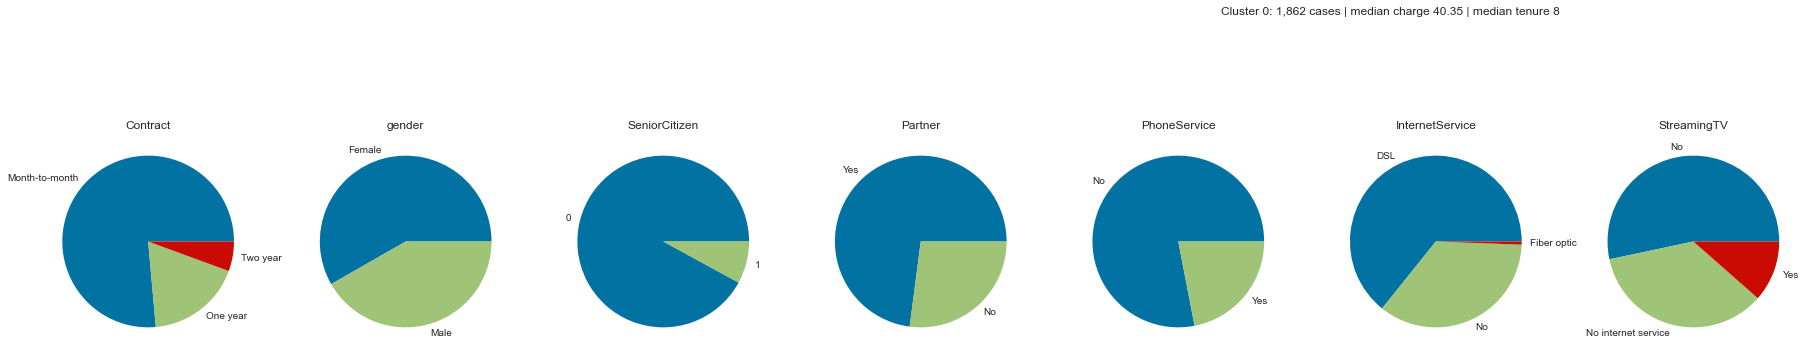

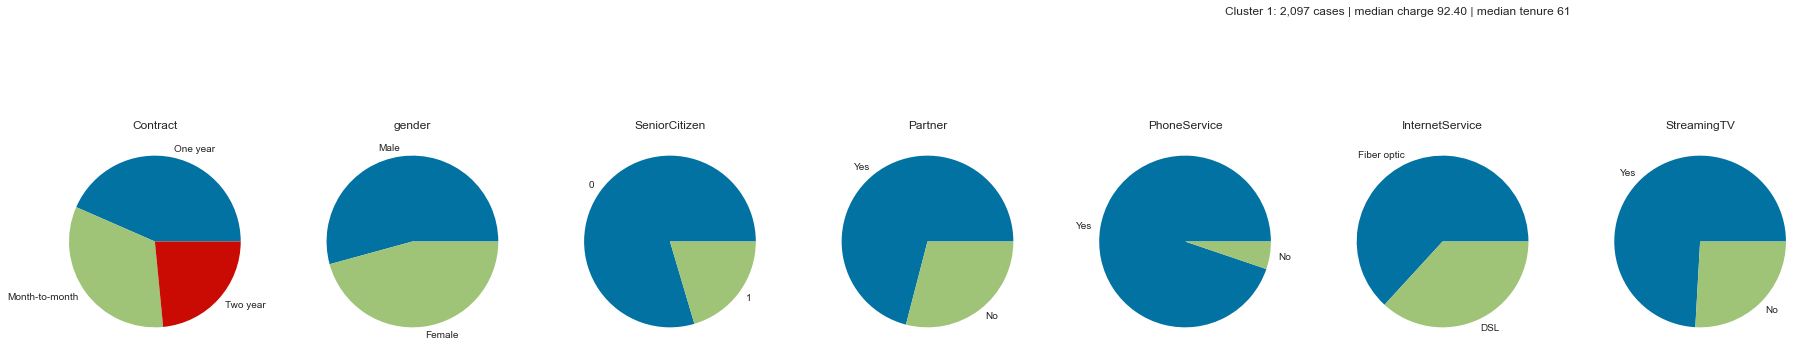

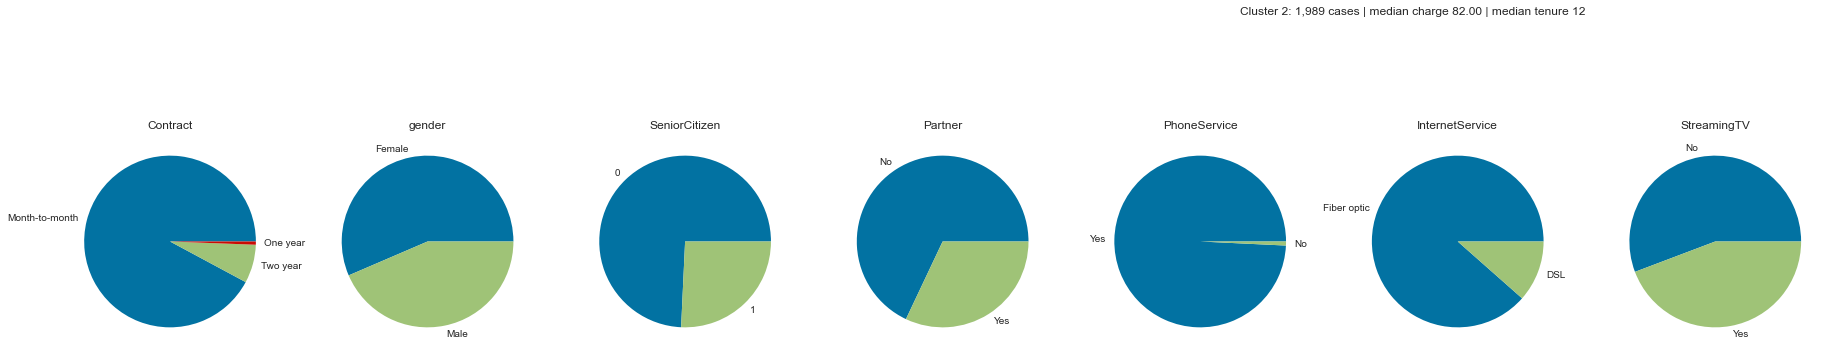

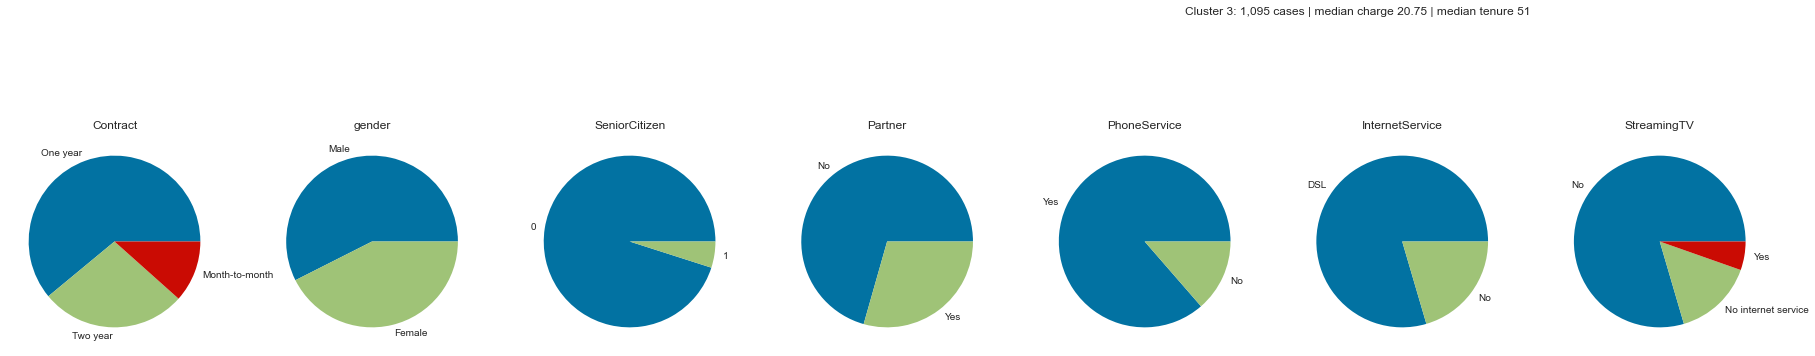

In [91]:
# call cluster profile function
cluster_profile(dfc1).T